In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import os
import pandas as pd
from torchvision.io import decode_image
import json
from torch.utils.data import Dataset, DataLoader
import cv2
import plotly_express as px

# CNN for digits recognition

## Preparing Datasets

In [93]:
# ---------- preprocess ----------
def leave_only_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_white = (0, 0, 200)
    upper_white = (180, 40, 255)
    mask = cv2.inRange(hsv, lower_white, upper_white)
    result = img.copy()
    result[mask == 0] = [0, 0, 0]
    return result

def preprocess_image(image_bgr):
    h, _ = image_bgr.shape[:2]
    crop = image_bgr[(h - 39):(h - 26), 107:210]  # (13, ~103, 3)
    crop = leave_only_white(crop)
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY) # (13, ~103)
    return gray

def is_blank(patch_gray, thr=0):
    return np.all(patch_gray <= thr)


In [69]:
# ---------------------------
# BUILDING MY OWN DATASET
# ---------------------------

class ScoreToDigitsDataset(Dataset):
    """
    Each __getitem__ returns one digit image and its class (0..9).
    Not labeled images are ignored.
    """
    def __init__(self, labels_json, img_dir,
                 n_slots=8, slot_w=8,
                 resize_hw=(20, 14),
                 return_blank=False):
        self.img_dir = img_dir
        self.n_slots = n_slots
        self.slot_w = slot_w
        self.resize_hw = resize_hw
        self.return_blank = return_blank

        with open(labels_json, "r", encoding="utf-8") as f:
            self.labels = json.load(f)

        # Build an index mapping: each sample = (image_path, slot_index, digit_class)
        self.samples = []
        for item in self.labels:
            fn = item.get("image")
            length = item.get("length", None)

            if fn is None:
                continue
            if length is None:
                continue  # skip unknown labels

            s = str(int(length))
            # align digits to the RIGHT: last digit goes to last slot
            # Example: length=62, s="62" => slot 7:'2', slot 6:'6'

            for k, ch in enumerate(s):
                slot = k
                if slot >= self.n_slots:
                    break
                self.samples.append((fn, slot, int(ch)))

            # include unknown/blank as class 10
            if self.return_blank:
                used_slots = set((self.n_slots - 1) - k for k in range(min(len(s), self.n_slots)))
                for slot in range(self.n_slots):
                    if slot not in used_slots:
                        self.samples.append((fn, slot, 10))  # unknown class

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fn, slot, digit_class = self.samples[idx]
        path = os.path.join(self.img_dir, fn)

        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(path)

        score_gray = preprocess_image(img)  # (13, W)

        x1 = max(0, slot * self.slot_w)
        x2 = min(score_gray.shape[1], (slot + 1) * self.slot_w)
        patch = score_gray[:, x1:x2]


        # Resize to match your network input size (so you don't have to rewrite ConvNet)
        H, W = self.resize_hw
        patch_resized = cv2.resize(patch, (W, H), interpolation=cv2.INTER_CUBIC)

        # to torch: [1, H, W], float32 in [0,1]
        x = torch.from_numpy(patch_resized).unsqueeze(0).float() / 255.0
        y = torch.tensor(digit_class, dtype=torch.long)

        return x, y


In [94]:
batch_size = 64
from torch.utils.data import ConcatDataset
from torch.utils.data import Subset

sample1_digits = ScoreToDigitsDataset(
    labels_json="../data/sample1/labels_score.json",
    img_dir="../data/sample1/screenshots",
    n_slots=8,
    slot_w=8,
    resize_hw=(20, 14),
    return_blank=False
)

sample2_digits = ScoreToDigitsDataset(
    labels_json="../data/sample2/labels_score.json",
    img_dir="../data/sample2/screenshots",
    n_slots=8,
    slot_w=8,
    resize_hw=(20, 14),
    return_blank=False
)

sample3_digits = ScoreToDigitsDataset(    
    labels_json="../data/sample3/labels_score.json",
    img_dir="../data/sample3/screenshots",
    n_slots=8,
    slot_w=8,
    resize_hw=(20, 14),
    return_blank=False
)

full_ds = ConcatDataset([sample1_digits, sample2_digits, sample3_digits])

full_loader = DataLoader(full_ds, batch_size=64, shuffle=True)


In [97]:
# Les classes étant unbalanced, on implémente une fonction stratify
from torch.utils.data import Subset
import random

def stratified_split(full_ds, train_size_per_class=40, num_classes=10):
    # Build index per class
    class_indices = {i: [] for i in range(num_classes)}
    for idx, (x, y) in enumerate(full_ds):
        label = y.item() if hasattr(y, 'item') else int(y)
        if label < num_classes:
            class_indices[label].append(idx)

    # Sample balanced train indices
    train_indices = []
    test_indices = []
    for i in range(num_classes):
        indices = class_indices[i]
        random.shuffle(indices)
        train_indices.extend(indices[:train_size_per_class])
        test_indices.extend(indices[train_size_per_class:])

    train_ds_balanced = Subset(full_ds, train_indices)
    test_ds_balanced = Subset(full_ds, test_indices)
    return train_ds_balanced, test_ds_balanced


train_ds_balanced, test_ds_balanced = stratified_split(full_ds, train_size_per_class=int(161*0.8))
train_loader_balanced = DataLoader(train_ds_balanced, batch_size=batch_size, shuffle=True)
test_loader_balanced = DataLoader(test_ds_balanced, batch_size=batch_size, shuffle=False)

### Exploring Datasets

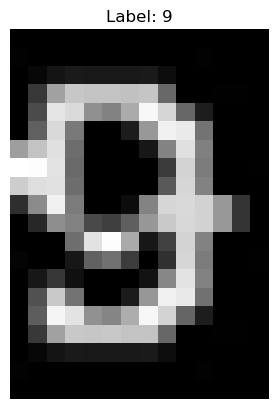

In [82]:
import matplotlib.pyplot as plt

def show_sample(dataset, idx):
    x, y = dataset[idx]
    img = x.squeeze(0).numpy()  # (20,14)

    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {y}")
    plt.axis("off")
    plt.show()

show_sample(full_ds, 121)

In [96]:
def digit_proportions_from_loader(loader, num_classes=10):
    counts = torch.zeros(num_classes, dtype=torch.long)
    total = 0
    for _, labels in loader:
        labels = labels.view(-1).to(torch.long)
        counts += torch.bincount(labels, minlength=num_classes)
        total += labels.numel()
    counts_dict = { str(i):int(counts[i]) for i in range(num_classes) }
    props_dict = { str(i): float(counts[i]) / total for i in range(num_classes) }
    return counts_dict, props_dict


full_counts, full_props_dict = digit_proportions_from_loader(full_loader)

print()
print("Full counts:", full_counts)
print("Full proportions:", full_props_dict)


Full counts: {'0': 161, '1': 405, '2': 202, '3': 213, '4': 180, '5': 210, '6': 169, '7': 224, '8': 216, '9': 193}
Full proportions: {'0': 0.07409111826967327, '1': 0.1863782788771284, '2': 0.09295904279797515, '3': 0.0980211688909342, '4': 0.08283479061205706, '5': 0.0966405890473999, '6': 0.07777266451909802, '7': 0.10308329498389324, '8': 0.09940174873446847, '9': 0.08881730326737229}


## Training / Testing CNN

### Building

In [129]:
# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters 
num_epochs = 10
batch_size = 64
learning_rate = 0.3

In [130]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        #self.dnjef = nn.Conv2d(in_channels=, out_channels=, kernel_size=)
        self.conv1 = nn.Conv2d(1, 3, 5) # I only have 1 channel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 1, 80)
        self.fc2 = nn.Linear(80, 50)
        self.fc3 = nn.Linear(50, 10) # predict 10 classes for the 10 digits.

    def forward(self, x):
        # -> n_batch, 1, 30, 65
        x = self.pool(F.relu(self.conv1(x)))  # -> nn_batch, 3, 13, 30
        x = (F.relu(self.conv2(x)))  # -> n_batch, 12, 4, 13
        x = x.view(-1, 12 * 4 * 1)            # -> n_batch, 400
        x = F.relu(self.fc1(x))               # -> n_batch, 120
        x = F.relu(self.fc2(x))               # -> n_batch, 84
        x = self.fc3(x)                       # -> n_batch, 10
        return x

model = ConvNet().to(device)

#relevant in classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

"""
# relevant for regression
criterion = nn.L1Loss() #nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
"""

'\n# relevant for regression\ncriterion = nn.L1Loss() #nn.MSELoss() \noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\n'

In [131]:
# loss curve over epochs

train_losses = []
test_losses = []
train_accs = []
test_accs = []
train_accs_per_class = {}
test_accs_per_class = {}

for epoch in range(num_epochs):
    # -------------------
    # TRAIN
    # -------------------
    model.train()
    train_loss_sum = 0.0
    train_n = 0
    correct = 0
    total=0

    for images, labels in train_loader_balanced: #train_loader
        images = images.to(device)
        labels = labels.to(device)  # [B]

        outputs = model(images)     # [B,10]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        train_loss_sum += loss.item() * bs
        train_n += bs

        # accuracy --------
        preds = torch.argmax(outputs, dim=1)  # [B]
        correct += (preds == labels).sum().item()
        total += bs

        ...

    avg_train_loss = train_loss_sum / train_n
    train_losses.append(avg_train_loss)
    
    avg_train_acc = correct / total
    train_accs.append(avg_train_acc)

    # -------------------
    # TEST (eval)
    # -------------------
    model.eval()
    test_loss_sum = 0.0
    test_n = 0
    correct = 0
    total=0

    with torch.no_grad(): # avoid back-propagation in testing
        for images, labels in test_loader_balanced: #test_loader
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            test_loss_sum += loss.item() * bs
            test_n += bs

            preds = torch.argmax(outputs, dim=1)  # [B]
            correct += (preds == labels).sum().item()
            total += bs

    avg_test_loss = test_loss_sum / test_n
    avg_test_acc = correct / total

    test_losses.append(avg_test_loss)
    test_accs.append(avg_test_acc)


    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}"
        f"Train Acc: {avg_train_acc:.4f} | Test Acc: {avg_test_acc:.4f}"

    )

print("Finished Training")


Epoch [1/10] Train Loss: 2.3043 | Test Loss: 2.3005Train Acc: 0.0938 | Test Acc: 0.0985
Epoch [2/10] Train Loss: 2.3006 | Test Loss: 2.2939Train Acc: 0.0859 | Test Acc: 0.0985
Epoch [3/10] Train Loss: 2.2893 | Test Loss: 2.2589Train Acc: 0.1836 | Test Acc: 0.4233
Epoch [4/10] Train Loss: 2.1485 | Test Loss: 1.4812Train Acc: 0.3469 | Test Acc: 0.4334
Epoch [5/10] Train Loss: 1.5720 | Test Loss: 2.1805Train Acc: 0.4734 | Test Acc: 0.2856
Epoch [6/10] Train Loss: 1.4724 | Test Loss: 1.3265Train Acc: 0.5586 | Test Acc: 0.7312
Epoch [7/10] Train Loss: 0.7077 | Test Loss: 0.3392Train Acc: 0.7898 | Test Acc: 0.9059
Epoch [8/10] Train Loss: 0.1752 | Test Loss: 0.0958Train Acc: 0.9523 | Test Acc: 0.9832
Epoch [9/10] Train Loss: 0.1104 | Test Loss: 0.0886Train Acc: 0.9727 | Test Acc: 0.9843
Epoch [10/10] Train Loss: 0.0881 | Test Loss: 0.0808Train Acc: 0.9844 | Test Acc: 0.9854
Finished Training


### Testing

In [132]:
# -------------------
# Plot loss curves
# -------------------
df_loss = pd.DataFrame({
    "epoch": list(range(1, num_epochs + 1)),
    "train_loss": train_losses,
    "test_loss": test_losses
})

df_long = df_loss.melt(id_vars="epoch", var_name="split", value_name="loss")

fig = px.line(
    df_long,
    x="epoch",
    y="loss",
    color="split",
    markers=True,
    title="Training vs Testing Loss (per epoch)"
)
fig.show()

df_acc = pd.DataFrame({
    "epoch": list(range(1, num_epochs + 1)),
    "train_acc": train_accs,
    "test_acc": test_accs
})
df_long = df_acc.melt(id_vars="epoch", var_name="split", value_name="accuracy")

fig = px.line(
    df_long,
    x="epoch",
    y="accuracy",
    color="split",
    markers=True,
    title="Training vs Testing Loss (per epoch)"
)
fig.show()


print("Saved: loss_curves.html")


Saved: loss_curves.html


### Saving

In [133]:
# Save model
PATH = "./cnn.pth"
#torch.save(model.state_dict(), PATH)
print("Saved: loss_curves.html")


Saved: loss_curves.html


num_epochs = 10
batch_size = 64
learning_rate = 0.1
```
Epoch [1/10] Train Loss: 2.3039 | Test Loss: 2.3267Train Acc: 0.1031 | Test Acc: 0.0829
Epoch [2/10] Train Loss: 2.3008 | Test Loss: 2.3182Train Acc: 0.1078 | Test Acc: 0.1064
Epoch [3/10] Train Loss: 2.2980 | Test Loss: 2.3111Train Acc: 0.1664 | Test Acc: 0.1982
Epoch [4/10] Train Loss: 2.2943 | Test Loss: 2.3042Train Acc: 0.2992 | Test Acc: 0.2251
Epoch [5/10] Train Loss: 2.2879 | Test Loss: 2.2944Train Acc: 0.2578 | Test Acc: 0.2396
Epoch [6/10] Train Loss: 2.2764 | Test Loss: 2.2784Train Acc: 0.3156 | Test Acc: 0.2990
Epoch [7/10] Train Loss: 2.2516 | Test Loss: 2.2423Train Acc: 0.4547 | Test Acc: 0.3953
Epoch [8/10] Train Loss: 2.1576 | Test Loss: 2.0514Train Acc: 0.4672 | Test Acc: 0.4132
Epoch [9/10] Train Loss: 1.6665 | Test Loss: 1.1075Train Acc: 0.4766 | Test Acc: 0.5991
Epoch [10/10] Train Loss: 1.0252 | Test Loss: 0.6539Train Acc: 0.6789 | Test Acc: 0.7872
Finished Training
```

num_epochs = 10
batch_size = 64
learning_rate = 0.3
```
Epoch [1/10] Train Loss: 2.3047 | Test Loss: 2.3121Train Acc: 0.0977 | Test Acc: 0.1064
Epoch [2/10] Train Loss: 2.2922 | Test Loss: 2.2890Train Acc: 0.1313 | Test Acc: 0.1646
Epoch [3/10] Train Loss: 2.2039 | Test Loss: 1.9550Train Acc: 0.3258 | Test Acc: 0.6618
Epoch [4/10] Train Loss: 1.5425 | Test Loss: 0.8802Train Acc: 0.4539 | Test Acc: 0.6405
Epoch [5/10] Train Loss: 0.6361 | Test Loss: 0.1159Train Acc: 0.7953 | Test Acc: 0.9787
Epoch [6/10] Train Loss: 0.3368 | Test Loss: 0.1389Train Acc: 0.9195 | Test Acc: 0.9776
Epoch [7/10] Train Loss: 0.0867 | Test Loss: 0.0714Train Acc: 0.9844 | Test Acc: 0.9888
Epoch [8/10] Train Loss: 0.0666 | Test Loss: 0.0724Train Acc: 0.9875 | Test Acc: 0.9877
Epoch [9/10] Train Loss: 0.0607 | Test Loss: 0.0695Train Acc: 0.9891 | Test Acc: 0.9877
Epoch [10/10] Train Loss: 0.0555 | Test Loss: 0.0687Train Acc: 0.9883 | Test Acc: 0.9877
Finished Training
```

num_epochs = 20
batch_size = 64
learning_rate = 0.1
```
Epoch [1/20] Train Loss: 2.2972 | Test Loss: 2.2803Train Acc: 0.1555 | Test Acc: 0.3415
Epoch [2/20] Train Loss: 2.2806 | Test Loss: 2.2599Train Acc: 0.2672 | Test Acc: 0.4211
Epoch [3/20] Train Loss: 2.2387 | Test Loss: 2.1685Train Acc: 0.2859 | Test Acc: 0.4211
Epoch [4/20] Train Loss: 2.0399 | Test Loss: 1.8454Train Acc: 0.3141 | Test Acc: 0.3897
Epoch [5/20] Train Loss: 1.6109 | Test Loss: 1.1635Train Acc: 0.4219 | Test Acc: 0.6159
Epoch [6/20] Train Loss: 1.0098 | Test Loss: 0.5663Train Acc: 0.6602 | Test Acc: 0.8533
Epoch [7/20] Train Loss: 0.7419 | Test Loss: 0.2725Train Acc: 0.7875 | Test Acc: 0.9384
Epoch [8/20] Train Loss: 0.7828 | Test Loss: 1.6954Train Acc: 0.8000 | Test Acc: 0.3438
Epoch [9/20] Train Loss: 0.8822 | Test Loss: 0.4119Train Acc: 0.7406 | Test Acc: 0.8981
Epoch [10/20] Train Loss: 0.3553 | Test Loss: 0.2239Train Acc: 0.8898 | Test Acc: 0.9351
Epoch [11/20] Train Loss: 0.4492 | Test Loss: 0.1920Train Acc: 0.8773 | Test Acc: 0.9686
Epoch [12/20] Train Loss: 0.1972 | Test Loss: 0.1473Train Acc: 0.9570 | Test Acc: 0.9619
Epoch [13/20] Train Loss: 0.1595 | Test Loss: 0.1063Train Acc: 0.9672 | Test Acc: 0.9810
Epoch [14/20] Train Loss: 0.1365 | Test Loss: 0.0973Train Acc: 0.9688 | Test Acc: 0.9810
Epoch [15/20] Train Loss: 0.1156 | Test Loss: 0.1271Train Acc: 0.9727 | Test Acc: 0.9798
Epoch [16/20] Train Loss: 0.1017 | Test Loss: 0.0894Train Acc: 0.9758 | Test Acc: 0.9877
Epoch [17/20] Train Loss: 0.0877 | Test Loss: 0.0813Train Acc: 0.9836 | Test Acc: 0.9866
Epoch [18/20] Train Loss: 0.0784 | Test Loss: 0.0771Train Acc: 0.9836 | Test Acc: 0.9877
Epoch [19/20] Train Loss: 0.0822 | Test Loss: 0.0759Train Acc: 0.9836 | Test Acc: 0.9877
Epoch [20/20] Train Loss: 0.0678 | Test Loss: 0.1159Train Acc: 0.9875 | Test Acc: 0.9798
```
